In [1]:
from RL.Env import Env
from RL.Agent import Agent
from Training import data_spilt, ReadH5d, create_data_loader
from Training import train_seg_net, test_seg_net
from Training import test_agent
from monai.transforms import *
from monai.networks.nets import DynUNet, SwinUNETR
from monai.losses import DiceFocalLoss
import torch
import random
from torch.distributions.categorical import Categorical


batch_size=6
num_epoch=1000



seg_list, rl_list, holdout_list = data_spilt('./picai_h5', 110, 100, 10)
seg_list_promise, rl_list_promise, holdout_list_promise = data_spilt('./promise_h5', 231, 180, 20)

train_list = rl_list + rl_list_promise
test_list = holdout_list + holdout_list_promise



device = 'cpu'
seg_model = SwinUNETR(
    img_size = (128, 128, 32),
    in_channels = 2,
    out_channels = 1,
    depths = (2, 2, 2, 2),
    num_heads = (3, 6, 12, 24),
    drop_rate = 0.1,
    attn_drop_rate = 0.1,
    dropout_path_rate = 0.1,
    downsample="mergingv2",
    use_v2=True,
)
seg_model.load_state_dict(torch.load("./models/segmentation.ptm", map_location=device, weights_only=True))
seg_model.eval()


learn_length = 30
batch_size = 10
n_epochs = 3


agent = Agent(gamma = 0.58, alpha=0.0001, batch_size=batch_size, n_epochs=n_epochs, device=device)
agent.load_models('./models/rl_models/actor.ptm')
test_result_list = []


# train_list = ['./picai_h5/3.h5']
test_list = holdout_list

dice_acc = []
for num_env in range(1): # loop over dataset (patients)
    agent.memory.clear_memory()
    train_dir = random.choice(test_list)
    env = Env(train_dir, seg_model, 1, device)
    print(env.get_all_accuracy())
    obs = env.reset()
    for _ in range(learn_length):
        dice_acc.append(env.calculate_current_accuracy())
        action = agent.choose_action(obs.unsqueeze(0).to(device), noise=0.)
        next_obs, reward = env.step_train(action)
        agent.remember(obs, action, reward)

        # if (_ + 1) % learn_length == 0:
        #     agent.learn()

        obs = next_obs.clone()
        
        
state_arr, action_arr, reward_arr, batches = \
            agent.memory.generate_batches()

/home/xiangcen/miniconda3/envs/dl/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


actor loaded!
(0.8307941541287951, 0.7053701015837197, 0.7925783483049638)


In [ ]:
from RL.custom_net import vit_classfier


rm = vit_classfier(out_feature = 1)
rm.load_state_dict(torch.load("./models/rm.ptm", map_location=device, weights_only=True))



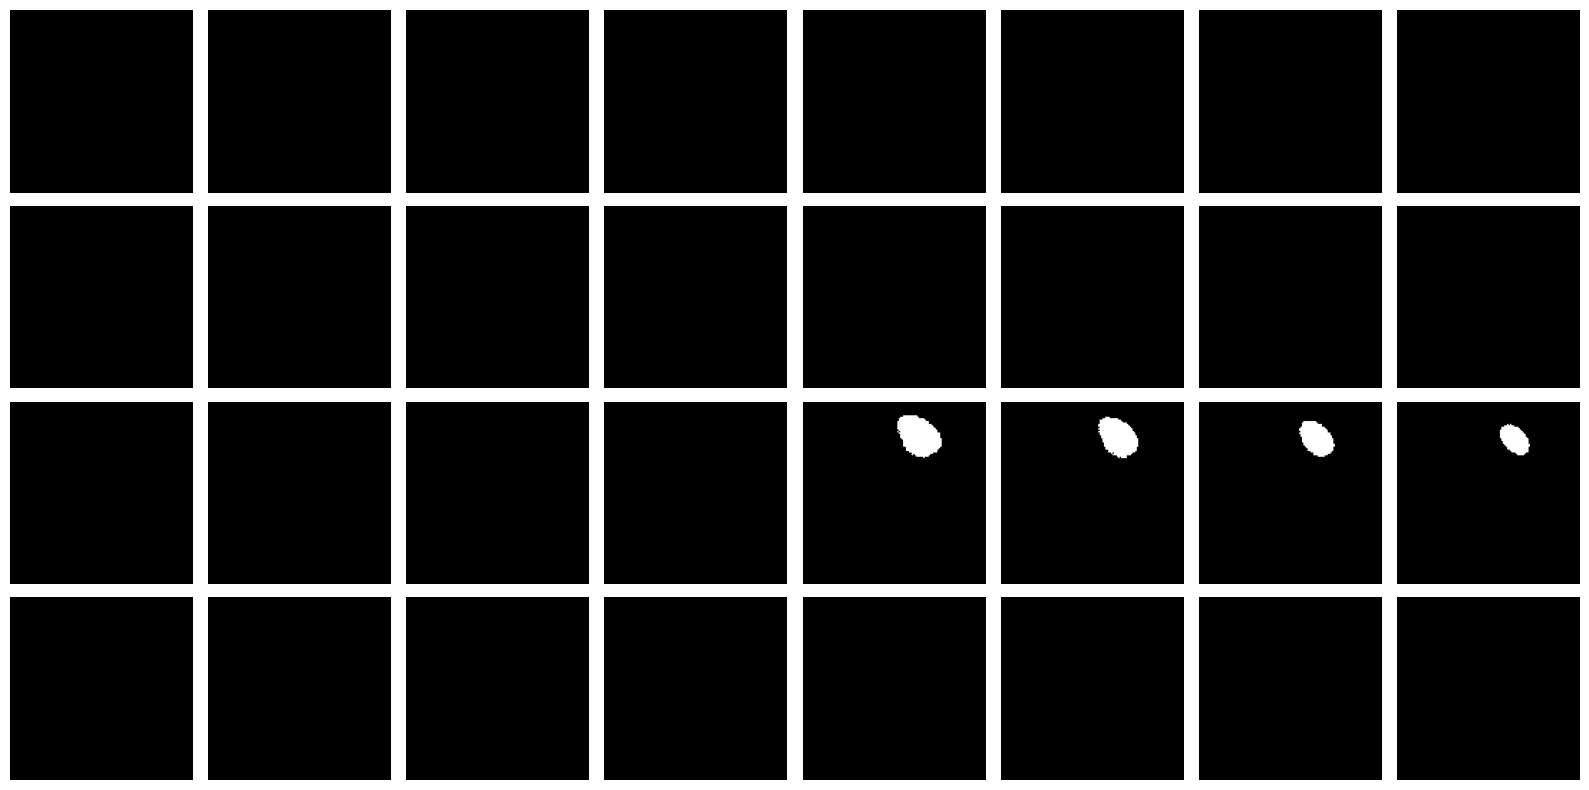

In [15]:
import matplotlib.pyplot as plt
rows = 4
cols = 8

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))  # Adjust figsize as needed


index = 1

# Plot each image
for i, ax in enumerate(axes.flat):
    
    ax.imshow(state_arr[index][2, :, :, i], cmap='gray')  # Use appropriate colormap (e.g., 'gray' or 'viridis'), cmap='gray'
    # ax.imshow(env.both_seg[0, :, :, i], cmap='gray')
    
    ax.axis('off')  # Hide axis


# Adjust layout
plt.tight_layout()

In [16]:
img = state_arr[index].unsqueeze(0).to(device)
rm(img)

tensor([[0.1443]], grad_fn=<AddmmBackward0>)